In [1]:
import cdsapi
import asf_search as asf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from collections import defaultdict

import pickle
from tqdm import tqdm
from zipfile import ZipFile
import os
import getpass

import itertools

import shutil

import xsar
import xarray as xr

In [22]:
download_dir = './mixed_land/'
out_dir = './out/sar_segments/'

  0%|                                                                 | 0/3 [00:00<?, ?it/s]

S1A_IW_GRDH_1SDV_20210117T174126_20210117T174151_036181_043E0C_F018.SAFE
land in image


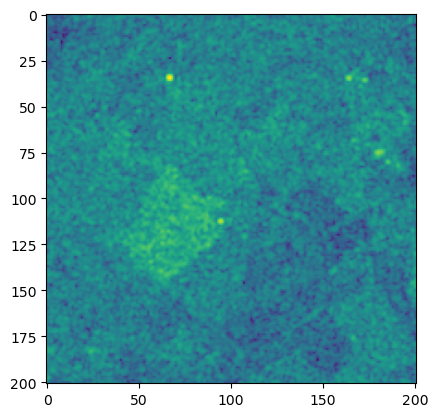

land in image


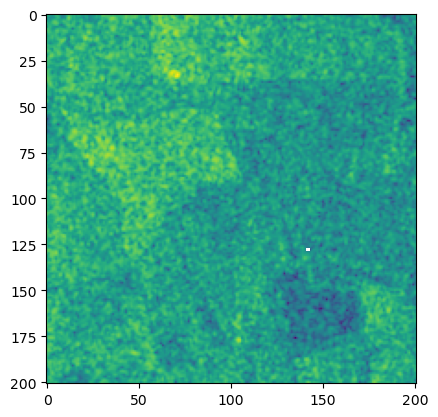

noland


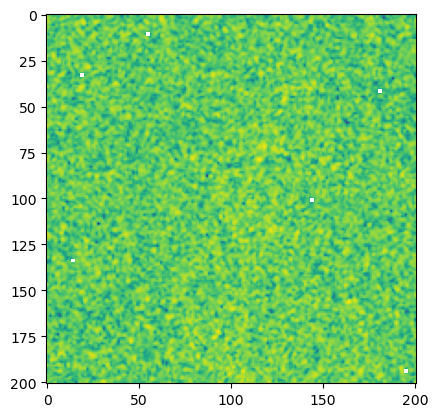

 33%|███████████████████                                      | 1/3 [00:05<00:11,  5.63s/it]

S1B_IW_GRDH_1SDV_20210115T055800_20210115T055825_025161_02FEEB_B85E.SAFE
land in image


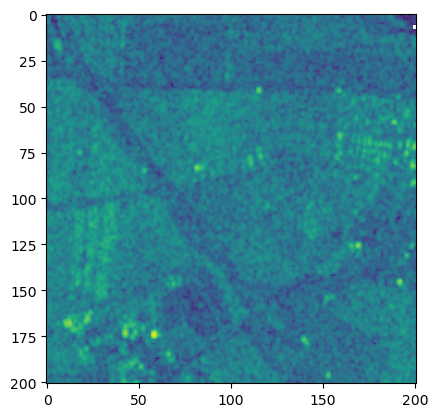

land in image


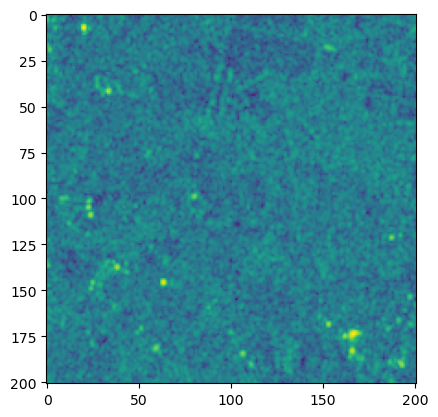

noland


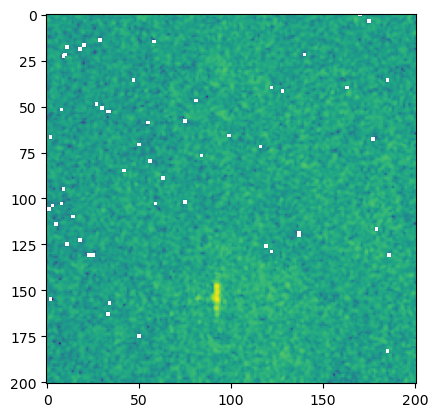

 67%|██████████████████████████████████████                   | 2/3 [00:11<00:05,  5.71s/it]

S1B_EW_GRDM_1SDH_20200201T051240_20200201T051344_020071_025FC8_CFA2.SAFE
noland


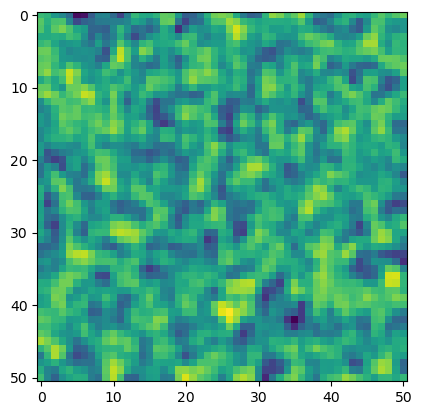

land in image


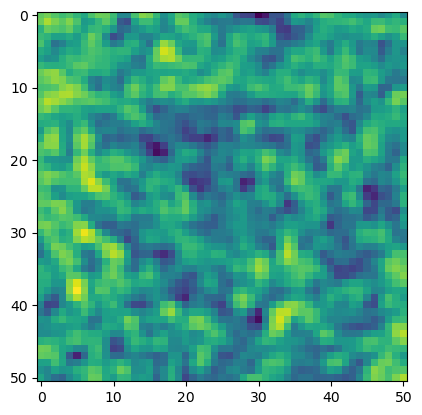

land in image


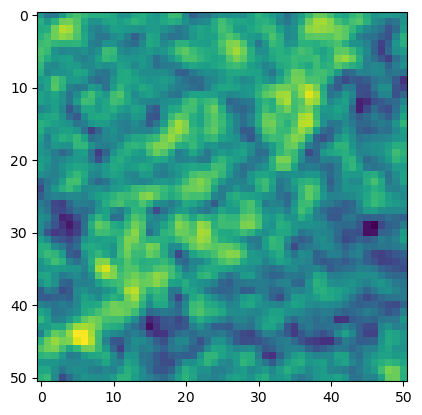

100%|█████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.08s/it]


In [28]:
record_dict = defaultdict(list)
name_counter = 0
box_size = 2000 # 2km

for file_name in tqdm(os.listdir(download_dir)):
     if file_name.endswith('.SAFE'):
        full_name = download_dir + file_name
        img_name = file_name.split('.')[0]
        print(file_name)
        
        sar_meta = xsar.Sentinel1Meta(full_name)
        sar_ds = xsar.Sentinel1Dataset(sar_meta)
        dist = {
            'line' : int(np.round(box_size / 2 / sar_meta.pixel_line_m)),
            'sample': int(np.round(box_size / 2 / sar_meta.pixel_sample_m))
        }
        
        line_max = sar_ds.dataset.line[-1].values
        sample_max = sar_ds.dataset.sample[-1].values
        
        lines = np.random.choice(sar_ds.dataset.line, 3)    
        samples = np.random.choice(sar_ds.dataset.sample, 3)
        
        for line, sample in zip(lines, samples):
            line_in_range   = (0 <= line - dist['line']) and \
                                   (line + dist['line'] <= line_max)

            sample_in_range = (0 <= sample - dist['sample']) and \
                                   (sample + dist['sample'] <= sample_max)

            if not (line_in_range and sample_in_range):
                print('2x2km not possible around coord')
                continue

            small_sar = sar_ds.dataset.sel(
                line=slice(line - dist['line'], line + dist['line']),
                sample=slice(sample - dist['sample'], sample + dist['sample'])
            )

            if np.any(small_sar.land_mask):
                print('land in image')

            else:
                print('noland')
                
            plt.imshow(10 * np.log10(small_sar.sigma0.isel(pol=0)))
            plt.show()


In [30]:
name_counter = 0
box_size = 2000 # 2km

for file_name in os.listdir(download_dir):
     if file_name.endswith('.SAFE'):
        full_name = download_dir + file_name
        img_name = file_name.split('.')[0]
        print(file_name)
        
        sar_meta = xsar.Sentinel1Meta(full_name)
        sar_ds = xsar.Sentinel1Dataset(sar_meta)
        dist = {
            'line' : int(np.round(box_size / 2 / sar_meta.pixel_line_m)),
            'sample': int(np.round(box_size / 2 / sar_meta.pixel_sample_m))
        }
        
        line_max = sar_ds.dataset.line[-1].values
        sample_max = sar_ds.dataset.sample[-1].values
        
        lines = np.random.choice(sar_ds.dataset.line, 300)    
        samples = np.random.choice(sar_ds.dataset.sample, 300)
        
        for line, sample in tqdm(zip(lines, samples), total = 300):
            line_in_range   = (0 <= line - dist['line']) and \
                                   (line + dist['line'] <= line_max)

            sample_in_range = (0 <= sample - dist['sample']) and \
                                   (sample + dist['sample'] <= sample_max)

            if not (line_in_range and sample_in_range):
                continue

            small_sar = sar_ds.dataset.sel(
                line=slice(line - dist['line'], line + dist['line']),
                sample=slice(sample - dist['sample'], sample + dist['sample'])
            )
         
                
            del small_sar['spatial_ref']
            
            out_name = f'{name_counter}.nc'    
                  
            extract_ds = xr.combine_by_coords([
                small_sar.land_mask,
                small_sar.longitude,
                small_sar.latitude, 
                small_sar.sigma0
            ])      
            
            if np.any(small_sar.land_mask):
                extract_ds.to_netcdf(path='./out/homogenuity/land/'+out_name)
            else:
                extract_ds.to_netcdf(path='./out/homogenuity/noland/'+out_name)
            
            name_counter += 1

S1A_IW_GRDH_1SDV_20210117T174126_20210117T174151_036181_043E0C_F018.SAFE


100%|█████████████████████████████████████████████████████| 300/300 [04:48<00:00,  1.04it/s]


S1B_IW_GRDH_1SDV_20210115T055800_20210115T055825_025161_02FEEB_B85E.SAFE


100%|█████████████████████████████████████████████████████| 300/300 [04:43<00:00,  1.06it/s]


S1B_EW_GRDM_1SDH_20200201T051240_20200201T051344_020071_025FC8_CFA2.SAFE


100%|█████████████████████████████████████████████████████| 300/300 [05:02<00:00,  1.01s/it]
